In [9]:
#### Notebook for QC comparing all APEX Datasets
# Analysis Includes
# Correlation between intensities in all experiments
# Shared protein intersections across experiments

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap as cm
import itertools
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

workdir = "/Users/priyaveeraraghavan/Documents/GitHub/inflame/paper_analysis/"

In [5]:
nigericin_nlrp3_apex_df = pd.read_csv(workdir+'data/all_stats_results_Nigericin_1peptide_Tukey.csv')
cl097_nlrp3_apex_df = pd.read_csv(workdir+'data/all_stats_results_NL3CL097_1peptide_medianPolish.csv')
nigericin_p4c_apex_df = pd.read_csv(workdir+'data/all_stats_results_P4C_Nigericin_1peptide_medianPolish.csv')
cl097_p4c_apex_df = pd.read_csv(workdir+'data/all_stats_results_P4C_CL097_1peptide_medianPolish.csv')
lps_only_df = pd.read_csv('/Users/priyaveeraraghavan/Documents/GitHub/inflame/Proteomics_Visualization/data/apex/LPS_only/all_stats_results_exp1analysis1.csv')
single_plex_apex_df = pd.read_csv('/Users/priyaveeraraghavan/Documents/GitHub/inflame/Proteomics_Visualization/data/apex/single_plex_all_conditions/all_stats_results_APXP4CNLRP3_nobiotin.csv')

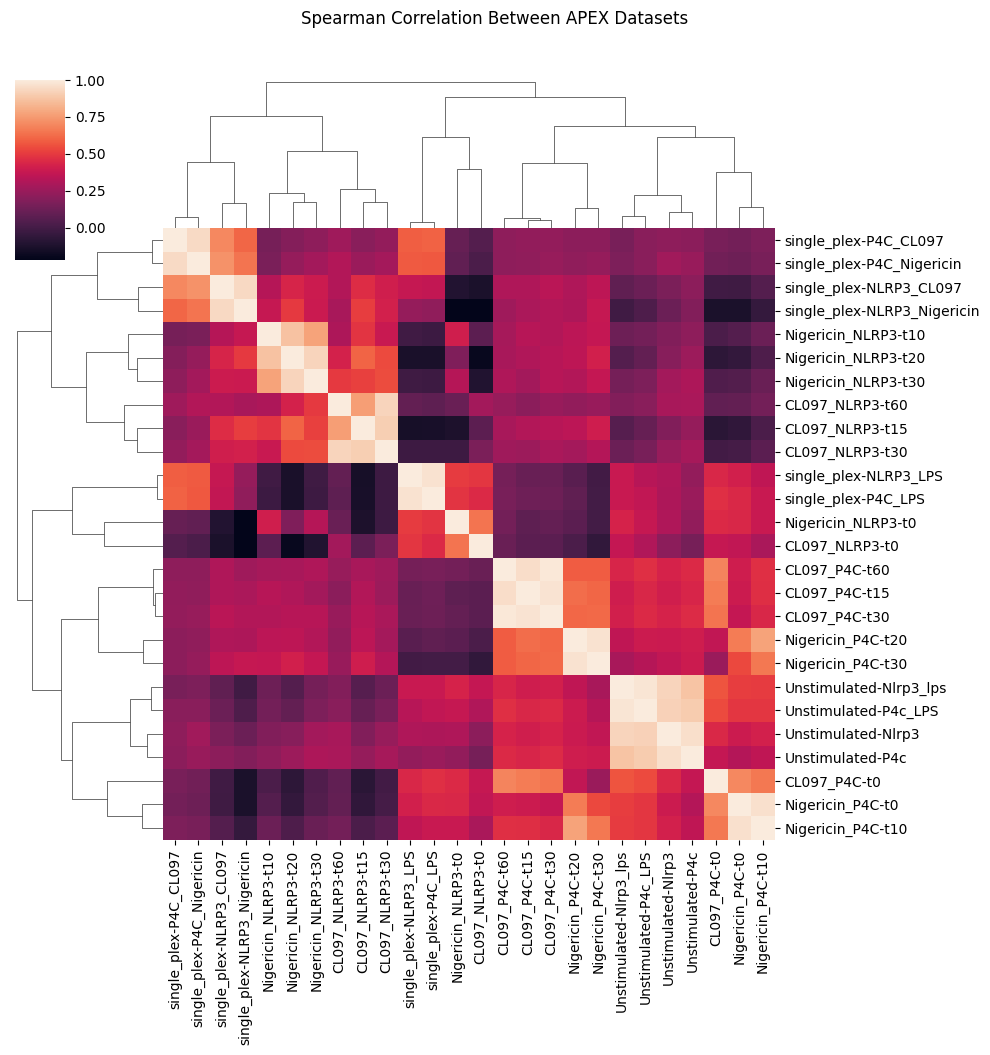

In [3]:
## First compare the single plex and multiple plex experiments
def select_format_intensity_cols(df, intensity_colnames, prefix):
    """
    Select and format intensity columns in a DataFrame.

    Parameters:
    - df: DataFrame containing intensity data
    - intensity_colnames: List of column names containing intensity values
    - prefix: Prefix to add to the new column names

    Returns:
    - DataFrame with selected and formatted intensity columns
    """

    # Create new column names with prefix added
    new_colnames = [f'{prefix}-{c}' for c in intensity_colnames]

    # Create a dictionary to map original column names to new column names
    rename_col_dict = dict(zip(intensity_colnames, new_colnames))

    # Make a copy of the DataFrame and rename selected columns using the dictionary
    df_select = df.copy().rename(columns=rename_col_dict)

    # Return the DataFrame with 'Reference' column and selected intensity columns
    return df_select[['Reference'] + new_colnames]


# Grab the mean intensities for all experiments    
mean_intensities = [
    select_format_intensity_cols(nigericin_nlrp3_apex_df, ['t'+str(i) for i in [0, 10, 20, 30]], 'Nigericin_NLRP3'),
    select_format_intensity_cols(nigericin_p4c_apex_df, ['t'+str(i) for i in [0, 10, 20, 30]], 'Nigericin_P4C'),
    select_format_intensity_cols(cl097_nlrp3_apex_df, ['t'+str(i) for i in [0, 15, 30, 60]], 'CL097_NLRP3'),
    select_format_intensity_cols(cl097_p4c_apex_df, ['t'+str(i) for i in [0, 15, 30, 60]], 'CL097_P4C'),
    select_format_intensity_cols(lps_only_df, [ 'Nlrp3', 'Nlrp3_lps', 'P4c', 'P4c_LPS'], 'Unstimulated'),
    select_format_intensity_cols(single_plex_apex_df, 
                                 ['NLRP3_CL097', 'NLRP3_LPS', 'NLRP3_Nigericin', 
                                  'P4C_CL097', 'P4C_LPS', 'P4C_Nigericin'], 'single_plex')]

# Merge the mean intensities on Reference column
# outer join to preserve all Reference values
mean_intensities_group = reduce(lambda x, y: x.merge(y, on='Reference', how='outer'), mean_intensities)

##
## Clustermap
##
# clean the df of Ref column and NAs
cluster_clean_intensities = mean_intensities_group.drop(columns='Reference').dropna()

# calc correlation matrix
correlation_matrix = cluster_clean_intensities.corr(method='spearman')

# plot clustermap
g = sns.clustermap(correlation_matrix)  
g.fig.suptitle('Spearman Correlation Between APEX Datasets', y=1.05)
plt.savefig(workdir + f"plots/APEX_all_experiment_compare_heatmap.pdf")

##
## Format for upset
##
long_intensities = mean_intensities_group.melt(id_vars='Reference', var_name='Experiment', value_name='Intensity').dropna().reset_index()
long_intensities['Experiment_Short'] = [x.split("-")[0] for x in long_intensities.Experiment]
long_intensities.to_csv(workdir + f"tables/APEX_all_experiment_compare_long_df.csv")

For the single-plex APEX experiment, look at the loadings

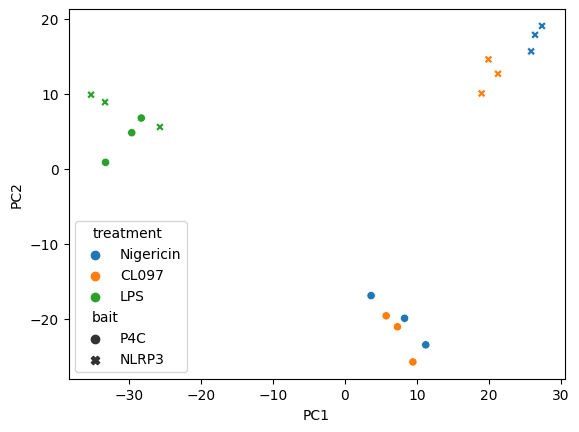

In [83]:
from sklearn.preprocessing import scale as sc
def embed_pca(input_df, scale=False):
    
    # scale features
    scaler = StandardScaler()
    if scale:
        df_scaled = scaler.fit_transform(input_df)
    else:
        # the other implementation
        df_scaled = input_df
        

    # PCA on features
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(df_scaled)

    pc_colnames = [f'PC{i}' for i in range(1, pca_res.shape[1]+1)]
    embed_df = pd.DataFrame(-pca_res, # negative for 180 rotation to match R
                            index=input_df.index,
                            columns=pc_colnames)

    embed_df = embed_df.reset_index(names='sample_id')
    embed_df['treatment'] = embed_df.sample_id.apply(lambda x: x.split('_')[1])
    embed_df['bait'] = embed_df.sample_id.apply(lambda x: x.split('_')[0])

    loadings = pd.DataFrame(-pca.components_.T, columns=pc_colnames, index=input_df.columns).reset_index() # negative for 180 rotation to match R
    
    return embed_df, loadings, pca


baits = ['P4C', 'NLRP3']
treatments = ['Nigericin', 'CL097', 'LPS']
cols = [f"{bait}_{treat}_{i}" for i in range(1,4) for bait, treat in itertools.product(baits, treatments)]

to_embed = single_plex_apex_df.set_index(['Reference', 'Gene.Symbol'])[cols].T
embed_df, loadings, pca = embed_pca(to_embed)


sns.scatterplot(embed_df, x='PC1', y='PC2', hue='treatment', style='bait')

loadings.to_csv(workdir + 'tables/single_plex_apex_gene_PCA_loadings.csv')

<Axes: xlabel='PC1_rank', ylabel='PC1'>

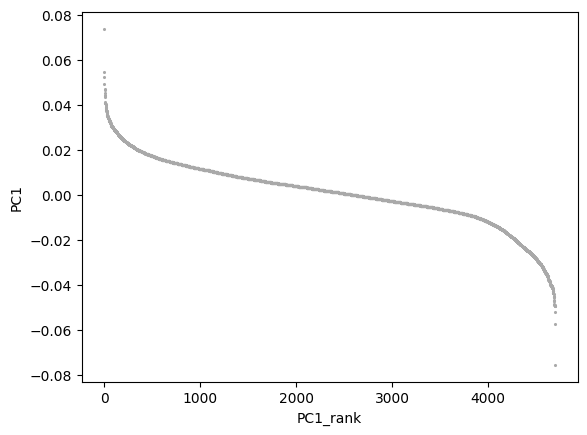

In [80]:
pc_col = 'PC1'
loading_sorted = loadings.sort_values(pc_col, ascending=False)
loading_sorted[pc_col+'_rank'] = [i for i in range(loading_sorted.shape[0])]
sns.scatterplot(loading_sorted, x=pc_col+'_rank', y=pc_col, color='darkgray', linewidth=0, s=5)

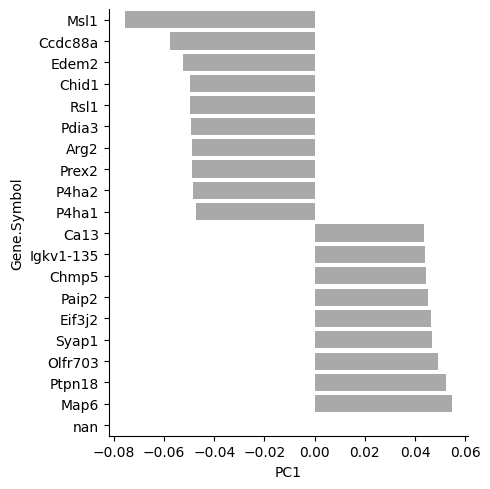

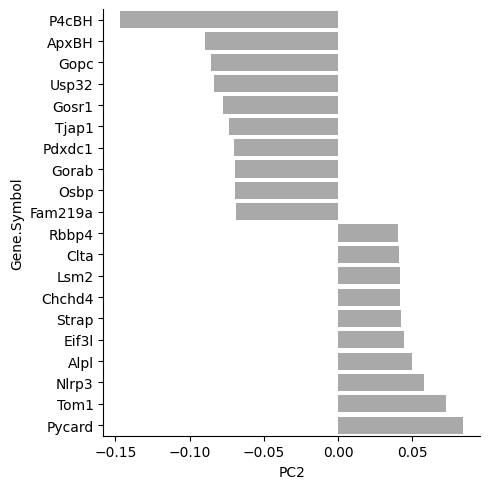

In [81]:

# plot loadings for top 10 and bottom 10 for each
def plot_max_val_loadings(loadings, pc_col, num):
    toplot = pd.concat([loadings.nsmallest(num, pc_col),
               loadings.nlargest(num, pc_col).sort_values(pc_col)])
    sns.catplot(toplot, y='Gene.Symbol', x=pc_col, order=toplot['Gene.Symbol'], kind='bar', color='darkgray')

plot_max_val_loadings(loadings, 'PC1', 10)
plot_max_val_loadings(loadings, 'PC2', 10)

